In [1]:
# disable Tensorflow GPU 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from scipy import sparse

from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from keras.layers import Embedding
from keras import metrics
from keras import backend as K

from datetime import datetime
import pandas as pd
import pickle


Using TensorFlow backend.


In [4]:
# ---------------------- Get Sparse Matrix & Tags , Unigram, BIgram and Trigram ------------------
def get_sparse_n_tags(file_names, dataset_name):
    
    # load preprocessed dataset as dataframe
    LABEL_DATA = pd.read_csv(dataset_name, encoding = "ISO-8859-1", usecols=["label"])
    tags = LABEL_DATA.label
    
    # load sparse matrix
    unigram = sparse.load_npz(file_names[0]).toarray()
    bigram = sparse.load_npz(file_names[1]).toarray()
    trigram = sparse.load_npz(file_names[2]).toarray()
    
    return [unigram, bigram, trigram, tags]


sparse_file_names = [
                    "tfidf_mat_selection_unigram.npz",
                    "tfidf_mat_selection_bigram.npz",
                    "tfidf_mat_selection_trigram.npz"]
preprocessed_dataset_name = "Text_Preprocessing.csv"

sparse_unigram, sparse_bigram, sparse_trigram, tags = \
                        get_sparse_n_tags(sparse_file_names, preprocessed_dataset_name)

In [5]:
sparse_unigram.shape, sparse_bigram.shape, sparse_trigram.shape

((23225, 506), (23225, 514), (23225, 477))

In [6]:
# ---------------------------- SPLIT DATASET -----------------------------------------------
def split_dataset(sparse, tags, split_ratio):
    # split dataset 
    return train_test_split(sparse, tags, test_size=split_ratio, random_state=42) 


sparse_unigram_train, sparse_unigram_test, tags_train, tags_test = split_dataset(sparse_unigram, tags, 0.25)
sparse_bigram_train, sparse_bigram_test, tags_train, tags_test = split_dataset(sparse_bigram, tags, 0.25)
sparse_trigram_train, sparse_trigram_test, tags_train, tags_test = split_dataset(sparse_trigram, tags, 0.25)


In [7]:
# -------------- define custom metric : precission, recall and F1 score ---------------------

def rec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def prec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = prec(y_true, y_pred)
    recall = rec(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
def get_cnn_model(max_len = 1000):  
    model = Sequential()
    
    model.add(Embedding(max_len,
                        20,
                        input_length=max_len))
    # model.add(Dropout(0.2))
    model.add(Conv1D(64,
                    3,
                    padding='valid',
                    activation='relu',
                    strides=1))
    # model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1))
    model.add(Dropout(0.2))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', rec, prec])
    return model

def check_model(model,x,y): 
    #return model.fit(x,y,batch_size=63,epochs=20,verbose=1,validation_split=0.15)
    return model.fit(x, y, verbose=1, validation_split=0.2)


In [9]:
# ----------------------------- START TRAINING MODEL ------------------------------
EPOCHS = 25
BATCH_SIZE = 6


print("--------------------------------------------------------------------------")
print(" TRAIN UNIGRAM MODEL ")
estimator_unigram = KerasClassifier(build_fn=get_cnn_model, max_len = sparse_unigram_train.shape[1], epochs=EPOCHS, batch_size=BATCH_SIZE)
history_unigram = check_model(estimator_unigram,sparse_unigram_train, tags_train.ravel())

print("\n\n\n")
print("--------------------------------------------------------------------------")
print(" TRAIN BIGRAM MODEL ")
estimator_bigram = KerasClassifier(build_fn=get_cnn_model, max_len = sparse_bigram_train.shape[1], epochs=EPOCHS, batch_size=BATCH_SIZE)
history_bigram = check_model(estimator_bigram,sparse_bigram_train, tags_train.ravel())

print("\n\n\n")
print("--------------------------------------------------------------------------")
print(" TRAIN TRIGRAM MODEL ")
estimator_trigram = KerasClassifier(build_fn=get_cnn_model, max_len = sparse_trigram_train.shape[1], epochs=EPOCHS, batch_size=BATCH_SIZE)
history_trigram = check_model(estimator_trigram,sparse_trigram_train, tags_train.ravel())


print("\n\n\n")
print("--------------------------------------------------------------------------")
print(" TRAINING MODEL FINISH")

--------------------------------------------------------------------------
 TRAIN UNIGRAM MODEL 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 506, 20)           10120     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 504, 64)           3904      
_________________________________________________________________
activation_1 (Activation)    (None, 504, 64)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
_______________________

C:\Users\yunus\Anaconda3\envs\ROOT\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13934 samples, validate on 3484 samples
Epoch 1/25
13934/13934 [==============================] - 30s 2ms/step - loss: 0.6644 - acc: 0.6374 - rec: 6.4572e-04 - prec: 2.5111e-04 - val_loss: 0.6584 - val_acc: 0.6323 - val_rec: 0.0000e+00 - val_prec: 0.0000e+00
Epoch 2/25
13934/13934 [==============================] - 22s 2ms/step - loss: 0.6632 - acc: 0.6377 - rec: 0.0000e+00 - prec: 0.0000e+00 - val_loss: 0.6595 - val_acc: 0.6323 - val_rec: 0.0000e+00 - val_prec: 0.0000e+00
Epoch 3/25
13934/13934 [==============================] - 22s 2ms/step - loss: 0.6622 - acc: 0.6377 - rec: 0.0000e+00 - prec: 0.0000e+00 - val_loss: 0.6587 - val_acc: 0.6323 - val_rec: 0.0000e+00 - val_prec: 0.0000e+00
Epoch 4/25
13934/13934 [==============================] - 23s 2ms/step - loss: 0.6633 - acc: 0.6377 - rec: 0.0000e+00 - prec: 0.0000e+00 - val_loss: 0.6572 - val_acc: 0.6323 - val_rec: 0.0000e+00 - val_prec: 0.0000e+00
Epoch 5/25
13934/13934 [==============================] - 25s 2ms/step - lo

C:\Users\yunus\Anaconda3\envs\ROOT\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13934 samples, validate on 3484 samples
Epoch 1/25
13934/13934 [==============================] - 22s 2ms/step - loss: 0.6616 - acc: 0.6375 - rec: 0.0022 - prec: 0.0041 - val_loss: 0.6544 - val_acc: 0.6343 - val_rec: 0.0170 - val_prec: 0.0413
Epoch 2/25
13934/13934 [==============================] - 20s 1ms/step - loss: 0.6625 - acc: 0.6380 - rec: 0.0108 - prec: 0.0226 - val_loss: 0.6560 - val_acc: 0.6343 - val_rec: 0.0170 - val_prec: 0.0413
Epoch 3/25
13934/13934 [==============================] - 21s 1ms/step - loss: 0.6636 - acc: 0.6388 - rec: 0.0147 - prec: 0.0323 - val_loss: 0.6558 - val_acc: 0.6343 - val_rec: 0.0170 - val_prec: 0.0413
Epoch 4/25
13934/13934 [==============================] - 21s 2ms/step - loss: 0.6593 - acc: 0.6389 - rec: 0.0121 - prec: 0.0295 - val_loss: 0.6608 - val_acc: 0.6343 - val_rec: 0.0170 - val_prec: 0.0413
Epoch 5/25
13934/13934 [==============================] - 21s 2ms/step - loss: 0.6608 - acc: 0.6386 - rec: 0.0109 - prec: 0.0245 - val_loss

C:\Users\yunus\Anaconda3\envs\ROOT\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13934 samples, validate on 3484 samples
Epoch 1/25
13934/13934 [==============================] - 19s 1ms/step - loss: 0.6642 - acc: 0.6369 - rec: 0.0020 - prec: 0.0010 - val_loss: 0.6606 - val_acc: 0.6323 - val_rec: 0.0000e+00 - val_prec: 0.0000e+00
Epoch 2/25
13934/13934 [==============================] - 18s 1ms/step - loss: 0.6610 - acc: 0.6377 - rec: 0.0000e+00 - prec: 0.0000e+00 - val_loss: 0.6564 - val_acc: 0.6323 - val_rec: 0.0000e+00 - val_prec: 0.0000e+00
Epoch 3/25
13934/13934 [==============================] - 18s 1ms/step - loss: 0.6603 - acc: 0.6377 - rec: 0.0000e+00 - prec: 0.0000e+00 - val_loss: 0.6544 - val_acc: 0.6323 - val_rec: 0.0000e+00 - val_prec: 0.0000e+00
Epoch 4/25
13934/13934 [==============================] - 18s 1ms/step - loss: 0.6609 - acc: 0.6377 - rec: 0.0000e+00 - prec: 0.0000e+00 - val_loss: 0.6536 - val_acc: 0.6323 - val_rec: 0.0000e+00 - val_prec: 0.0000e+00
Epoch 5/25
13934/13934 [==============================] - 18s 1ms/step - loss: 0.66

In [10]:
# ------------------------------ EVALUATION MODEL --------------------------------
def print_cm(y_true, y_pred, labels_order) :
    df = pd.DataFrame(
                confusion_matrix(y_true, y_pred, labels=labels_order), 
                index=['target : 1', 'target : 0'], 
                columns=['pred : 1', 'pred : 0']
            )
    df.style.set_properties(**{'text-align': 'center'})
    return df


# evaluation model unigram
tags_unigram_pred = estimator_unigram.predict(sparse_unigram_test)
confusion_matrix_unigram = print_cm(tags_unigram_pred, tags_test, [1, 0])
report_unigram = classification_report(tags_unigram_pred, tags_test)
print("------------------- UNIGRAM -------------------------")
print(confusion_matrix_unigram)
print("\n")
print(report_unigram)


# evaluation model bigram
tags_bigram_pred = estimator_bigram.predict(sparse_bigram_test)
confusion_matrix_bigram = print_cm(tags_bigram_pred, tags_test, [1, 0])
report_bigram = classification_report(tags_bigram_pred, tags_test)
print("\n\n")
print("------------------- BIGRAM -------------------------")
print(confusion_matrix_bigram)
print("\n")
print(report_bigram)


# evaluation model trigram
tags_trigram_pred = estimator_trigram.predict(sparse_trigram_test)
confusion_matrix_trigram = print_cm(tags_trigram_pred, tags_test, [1, 0])
report_trigram = classification_report(tags_trigram_pred, tags_test)
print("\n\n")
print("------------------- TRIGRAM -------------------------")
print(confusion_matrix_trigram)
print("\n")
print(report_trigram)


C:\Users\yunus\Anaconda3\envs\ROOT\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------- UNIGRAM -------------------------
            pred : 1  pred : 0
target : 1         0         0
target : 0      2097      3710


              precision    recall  f1-score   support

           0       1.00      0.64      0.78      5807
           1       0.00      0.00      0.00         0

    accuracy                           0.64      5807
   macro avg       0.50      0.32      0.39      5807
weighted avg       1.00      0.64      0.78      5807




------------------- BIGRAM -------------------------
            pred : 1  pred : 0
target : 1        41        29
target : 0      2056      3681


              precision    recall  f1-score   support

           0       0.99      0.64      0.78      5737
           1       0.02      0.59      0.04        70

    accuracy                           0.64      5807
   macro avg       0.51      0.61      0.41      5807
weighted avg       0.98      0.64      0.77      5807




------------------- TRIGRAM ---------------

C:\Users\yunus\Anaconda3\envs\ROOT\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# ------------------------------ SAVE MODEL ------------------------------    

estimator_unigram.model.save("cnn_model_unigram.h5")
estimator_bigram.model.save("cnn_model_bigram.h5")
estimator_trigram.model.save("cnn_model_trigram.h5")

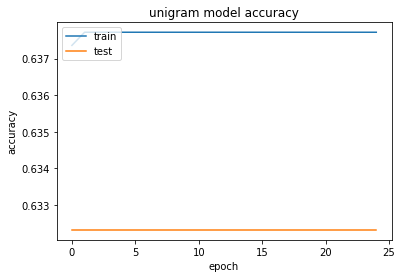

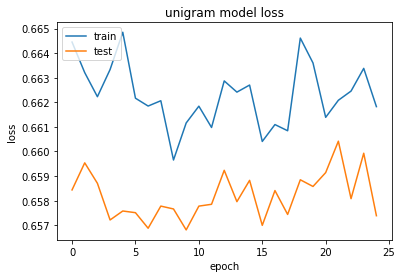

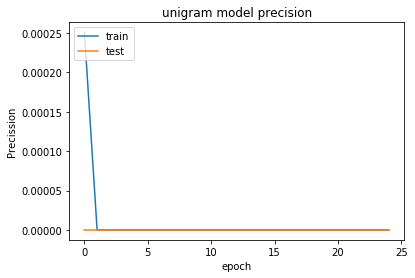

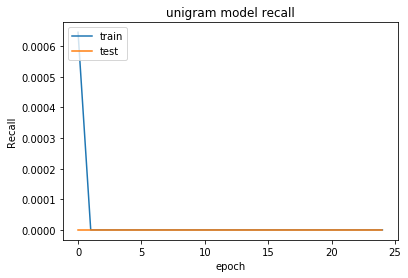

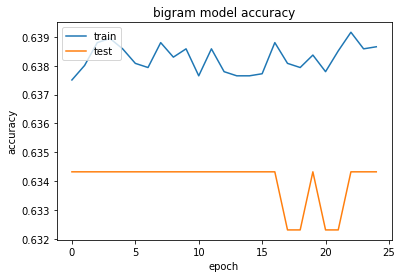

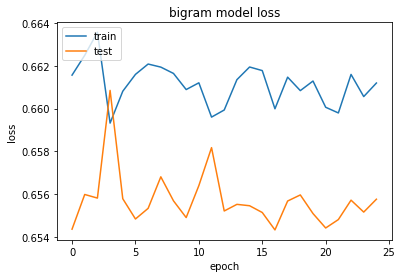

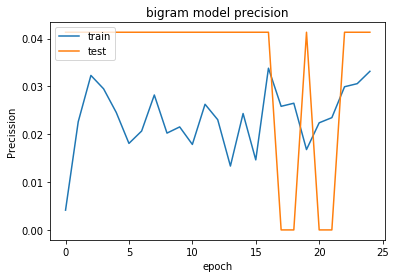

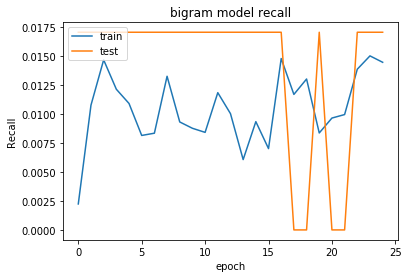

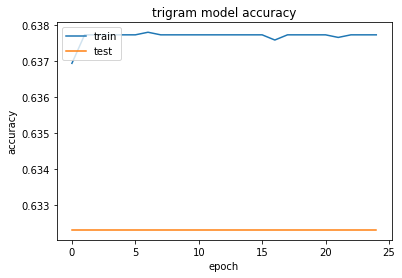

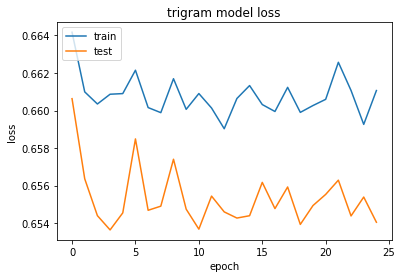

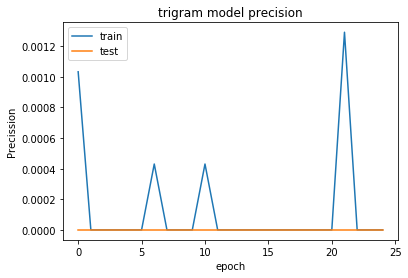

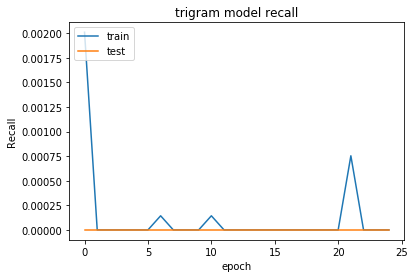

In [13]:
import matplotlib.pyplot as plt

def plot_history_model(history, name):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name + ' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for precision
    plt.plot(history.history['prec'])
    plt.plot(history.history['val_prec'])
    plt.title(name + ' model precision')
    plt.ylabel('Precission')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for precision
    plt.plot(history.history['rec'])
    plt.plot(history.history['val_rec'])
    plt.title(name + ' model recall')
    plt.ylabel('Recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

# plot training history - unigram
plot_history_model(history_unigram, "unigram")

# plot training history - bigram
plot_history_model(history_bigram, "bigram")

# plot training history - trigram
plot_history_model(history_trigram, "trigram")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 506, 20)           20000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 504, 64)           3904      
_________________________________________________________________
activation_7 (Activation)    (None, 504, 64)           0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
_________________________________________________________________
dropout_4 (Dropout)          (None, 1)                 0         
_________________________________________________________________
activation_8 (Activation)    (None, 1)                

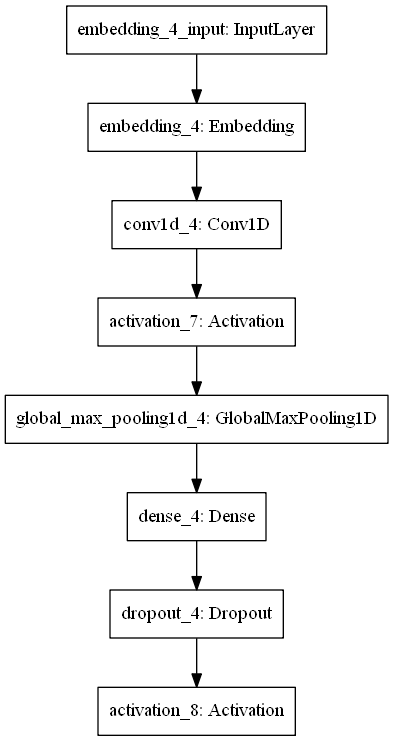

In [35]:
# save architecture 
from keras.utils import plot_model

def generate_model_architecture(filename, max_len):
    plot_model(get_cnn_model(max_len=max_len), 
               to_file=filename, 
               show_shapes=True, 
               show_layer_names=True)


generate_model_architecture('unigram_model_architecture.png',sparse_unigram_train.shape[1])
generate_model_architecture('bigram_model_architecture.png',sparse_bigram_train.shape[1])
generate_model_architecture('trigram_model_architecture.png',sparse_trigram_train.shape[1])